In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

We define some things for $\LaTeX$ here.
$
\def\D{\mathrm{d}}
\def\T{\mathsf{T}}
$

# A simplified model

Let's look at a simplified version of the model proposed by Moroney et al., 2019<sup>[1]</sup>. The simplified model is divided into a single solid phase and a liquid phase. Mass transfer between the phases is described by the following equation:

$$
\frac{\partial m_i}{\partial t} = k_{sl} A (c_s - c_l)
$$

Here, $\partial m_i / \partial t$ is the mass transfer rate of soluble coffee across the interface between the solid and liquid phases, $k_{sl}$ is the mass transfer coefficient, $A$ is the effective interface area, $c_s$ is the concentration of soluble coffee in the solid phase, and $c_l$ is the concentration in the liquid phase. We can express this in terms of the surface area per unit volume, $A_i$, for the coffee grains:

$$
\frac{\partial m_i}{\partial t} = k_{sl} A_i V_s (c_s - c_l)
$$

Here, $V_s$ is the volume of the solid phase. We can define the volume fraction of the solid phase as follows:

$$
\alpha_s = \frac{V_s}{V}
$$

where $V$ is the total volume of the packed bed. Then we have:

$$
\frac{\partial m_i}{\partial t} = k_{sl} A_i \alpha_s V (c_s - c_l)
$$

For the liquid phase, we introduce a fluid velocity $v_l$. Soluble coffee moves across the interface with the solid phase and also with the flow of water through the puck. This gives us:

$$
\frac{\partial m_l}{\partial t} = -v_l \frac{\partial m_l}{\partial z} + \frac{\partial m_i}{\partial t} = -v_l \frac{\partial m_l}{\partial z} + k_{sl} A_i \alpha_s V (c_s - c_l) \tag{1}
$$

For the solid phase, the only change in concentration comes from coffee moving across the interface with the liquid phase. So:

$$
\frac{\partial m_s}{\partial t} = -\frac{\partial m_i}{\partial t} = -k_{sl} A_i \alpha_s V (c_s - c_l) \tag{2}
$$

We want to express Equations (1) and (2) in terms of concentration. We can calculate the concentration of soluble coffee within the liquid phase as:

$$
c_l = \frac{m_l}{V_l} = \frac{m_l}{(1 - \alpha_s) V}
$$

The coffee grains have a porous structure, with intragranular porosity $\phi_v$ given by:

$$
\phi_v = \frac{V_v}{V_s}
$$

Here, $V_v$ is the volume of the pore space containing soluble coffee. Then we can calculate the concentration of soluble coffee within the pore space as:

$$
c_s = \frac{m_s}{V_v} = \frac{m_s}{\phi_v V_s} = \frac{m_s}{\phi_v \alpha_s V}
$$

Then Equations (1) and (2) become:

$$
\begin{gather}
\frac{\partial c_l}{\partial t} = -v_l \frac{\partial c_l}{\partial z} + \frac{k_{sl} A_i \alpha_s}{1 - \alpha_s} (c_s - c_l) \tag{3}\\
\frac{\partial c_s}{\partial t} = -\frac{k_{sl} A_i}{\phi_v} (c_s - c_l) \tag{4}
\end{gather}
$$

These are the same as Equations (10) and (11) in Moroney et al., with:

$$
k_{sl} = \frac{h_{sl}}{\alpha_s}, \quad A_i = \frac{6 \alpha_s}{d_s}, \quad 1 - \alpha_s = \alpha_l
$$

It will be easier to work with Equations (3) and (4) if we set:

$$
\boxed{
K_l = \frac{k_{sl} A_i \alpha_s}{1 - \alpha_s}, \quad K_s = \frac{k_{sl} A_i}{\phi_v}
}
$$

Then:

$$
\boxed{
\frac{\partial c_l}{\partial t} = -v_l \frac{\partial c_l}{\partial z} + K_l (c_s - c_l), \quad
\frac{\partial c_s}{\partial t} = -K_s (c_s - c_l)
}
$$

# The homogeneous solution

Let's look at a single horizontal slice of the packed bed, with thickness $\Delta z$. We arrange our measurements as shown in the figure below:

<img src=points.png width=500/>

We can use a backward difference to eliminate the spatial derivative. Then our system of equations becomes:

$$
\frac{\partial c_l}{\partial t} = -v_l \frac{c_l - c_l'}{\Delta z} + K_l \left( c_s - \frac{c_l + c_l'}{2} \right), \quad
\frac{\partial c_s}{\partial t} = -K_s \left( c_s - \frac{c_l + c_l'}{2} \right)
$$

These equations form a system of linear nonhomogeneous differential equations. We start by looking at the associated homogeneous equations, by setting $c_l' = 0$. As it happens, this corresponds with a single-layer model where fresh water is introduced at the top of the packed bed.

$$
\frac{\partial c_l}{\partial t} = -v_l \frac{c_l}{\Delta z} + K_l \left( c_s - \frac{c_l}{2} \right), \quad
\frac{\partial c_s}{\partial t} = -K_s \left( c_s - \frac{c_l}{2} \right)
$$

If we substitute $u_l = v_l / \Delta z$, we get:

$$
\begin{gather}
\frac{\partial c_l}{\partial t} = -u_l c_l + K_l \left( c_s - \frac{c_l}{2} \right), \tag{5} \\
\frac{\partial c_s}{\partial t} = -K_s \left( c_s - \frac{c_l}{2} \right) \tag{6}
\end{gather}
$$

We can solve this by the method of elimination. First we differentiate Equation (5):

$$
\frac{\partial^2}{\partial t^2} c_l = \left( -u_l - \frac{K_l}{2} \right) \frac{\partial}{\partial t} c_l + K_l \frac{\partial}{\partial t} c_s
$$

Now we substitute Equation (6):

$$
\frac{\partial^2}{\partial t^2} c_l = \left( -u_l - \frac{K_l}{2} \right) \frac{\partial}{\partial t} c_l - K_l K_s \left( c_s - \frac{c_l}{2} \right) \tag{7}
$$

If we express Equation (5) in terms of $c_s$, we get:

$$
K_l c_s = \frac{\partial}{\partial t} c_l + \left( u_l + \frac{K_l}{2} \right) c_l \tag{8}
$$

Substituting Equation (8) into Equation (7) gives us a second order linear homogeneous equation:

$$
\begin{align}
\frac{\partial^2}{\partial t^2} c_l &= \left( -u_l - \frac{K_l}{2} \right) \frac{\partial}{\partial t} c_l - K_s \left( \frac{\partial}{\partial t} c_l + \left( u_l + \frac{K_l}{2} \right) c_l \right) + K_l K_s \frac{c_l}{2} \\
&= \left( -u_l - \frac{K_l}{2} - K_s \right) \frac{\partial}{\partial t} c_l - K_s u_l c_l \tag{9}
\end{align}
$$

To solve this equation, we need to find the roots of the characteristic equation:

$$
\lambda^2 + \left( u_l + \frac{K_l}{2} + K_s \right) \lambda + K_s u_l = 0
$$

The roots are:

$$
\lambda_{1,2} = \frac{1}{2} \left( -\left( u_l + \frac{K_l}{2} + K_s \right) \pm \sqrt{\left( u_l + \frac{K_l}{2} + K_s \right)^2 - 4 K_s u_l} \right)
$$

The solution to Equation (9) is then:

$$
\begin{align}
c_l(t) &= C_1 e^{\lambda_1 t} + C_2 e^{\lambda_2 t} \\
&= C_1 e^{-\frac{A + B}{2} t} + C_2 e^{-\frac{A - B}{2} t} \tag{10}\\
\end{align}
$$

where

$$
\boxed{
A = u_l + \frac{K_l}{2} + K_s, \quad B = \sqrt{A^2 - 4 K_s u_l}
}
$$

To get an expression for $c_s(t)$, we differentiate Equation (10):

$$
\frac{\partial}{\partial t} c_l = -\frac{A + B}{2} C_1 e^{-\frac{A + B}{2} t} - \frac{A - B}{2} C_2 e^{-\frac{A - B}{2} t}
$$

and substitute Equation (5) on the left side:

$$
-u_l c_l + K_l \left( c_s - \frac{c_l}{2} \right) = -\frac{A + B}{2} C_1 e^{-\frac{A + B}{2} t} - \frac{A - B}{2} C_2 e^{-\frac{A - B}{2} t}
$$

Now we subsitute Equation (10) on the left side:

$$
K_l c_s - \left( u_l + \frac{K_l}{2} \right) \left( C_1 e^{-\frac{A + B}{2} t} + C_2 e^{-\frac{A - B}{2} t} \right) = -\frac{A + B}{2} C_1 e^{-\frac{A + B}{2} t} - \frac{A - B}{2} C_2 e^{-\frac{A - B}{2} t}
$$

This gives us:

$$
\begin{align}
c_s(t) &= \frac{1}{K_l} \left( u_l + \frac{K_l}{2} \right) \left( C_1 e^{-\frac{A + B}{2} t} + C_2 e^{-\frac{A - B}{2} t} \right) -\frac{A + B}{2 K_l} C_1 e^{-\frac{A + B}{2} t} - \frac{A - B}{2 K_l} C_2 e^{-\frac{A - B}{2} t} \\
&= \frac{A - K_s}{K_l} \left( C_1 e^{-\frac{A + B}{2} t} + C_2 e^{-\frac{A - B}{2} t} \right) -\frac{A + B}{2 K_l} C_1 e^{-\frac{A + B}{2} t} - \frac{A - B}{2 K_l} C_2 e^{-\frac{A - B}{2} t} \\
&= \left( -\frac{A + B}{2 K_l} + \frac{A - K_s}{K_l} \right) C_1 e^{-\frac{A + B}{2} t} + \left( -\frac{A - B}{2 K_l} + \frac{A - K_s}{K_l} \right) C_2 e^{-\frac{A - B}{2} t} \\
&= \frac{2 A - 2 K_s - A - B}{2 K_l} C_1 e^{-\frac{A + B}{2} t} + \frac{2 A - 2 K_s - A + B}{2 K_l} C_2 e^{-\frac{A - B}{2} t} \\
&= \frac{A - B - 2 K_s}{2 K_l} C_1 e^{-\frac{A + B}{2} t} + \frac{A + B - 2 K_s}{2 K_l} C_2 e^{-\frac{A - B}{2} t}
\end{align}
$$

If we set:

$$
\boxed{
Z_1 = \frac{A - B - 2 K_s}{2 K_l}, \quad Z_2 = \frac{A + B - 2 K_s}{2 K_l}
}
$$

then the solutions become:

$$
\boxed{
c_l(t) = C_1 e^{-\frac{A + B}{2} t} + C_2 e^{-\frac{A - B}{2} t}, \quad c_s(t) = Z_1 C_1 e^{-\frac{A + B}{2} t} + Z_2 C_2 e^{-\frac{A - B}{2} t}
}
$$

# Initial conditions

Evaluating the homogeneous solution at $t=0$, we get:

$$
c_l(0) = C_1 + C_2, \quad c_s(0) = Z_1 C_1 + Z_2 C_2
$$

Solving for $C_1$ and $C_2$:

$$
\begin{gather}
\begin{bmatrix}
c_l(0) \\ c_s(0)
\end{bmatrix}
=
\begin{bmatrix}
1 & 1 \\
Z_1 & Z_2
\end{bmatrix}
\begin{bmatrix}
C_1 \\ C_2
\end{bmatrix} \Rightarrow \\
\begin{bmatrix}
1 & 1 \\
Z_1 & Z_2
\end{bmatrix}^{-1}
\begin{bmatrix}
c_l(0) \\ c_s(0)
\end{bmatrix}
=
\begin{bmatrix}
C_1 \\ C_2
\end{bmatrix} \Rightarrow \\
\frac{1}{Z_2 - Z_1}
\begin{bmatrix}
Z_2 & -1 \\
-Z_1 & 1
\end{bmatrix}
\begin{bmatrix}
c_l(0) \\ c_s(0)
\end{bmatrix}
=
\begin{bmatrix}
C_1 \\ C_2
\end{bmatrix} \\
\end{gather}
$$

This gives us:

$$
\boxed{
C_1 = \frac{Z_2 c_l(0) - c_s(0)}{Z_2 - Z_1}, \quad C_2 = -\frac{Z_1 c_l(0) - c_s(0)}{Z_2 - Z_1}
}
$$

# Comparison with experimental data

Let's consider the single phase fine grind experiment from Moroney et al.:

| Paramter | Value |
|:-------:|:-:|
| $$v_l$$ | $$7.62 \times 10^{-3}\,\text{m}\,\text{s}^{-1}$$ |
| $$L$$ | $$0.0405\,\text{m}$$ |
| $$h_{sl}$$ | $$4.47076 \times 10^{-7}\,\text{m}\,\text{s}^{-1}$$ |
| $$A_i$$ | $$1.5083 \times 10^5\,\text{m}^{-1}$$ |
| $$\phi_v$$ | $$0.56$$  |
| $$\alpha_s$$ | $$0.8$$ |
| $$c_s(0)$$ | $$358.587\,\text{kg}\,\text{m}^3$$ |

The value of $h_{sl}$ given in the paper is incorrect. The value given, $4.31562 \times 10^{-4}\,\text{m}\,\text{s}^{-1}$, needs to be divided by the density of water at room temperature, $965.3\,\text{kg}\,\text{m}^{-3}$, which gives $h_{sl} = 4.47076 \times 10^{-7}\,\text{m}\,\text{s}^{-1}$.

We get $A_i$ using this equation given in the paper:

$$
A_i = \frac{6 \alpha_s}{d_s} = \frac{6 \times 0.8}{3.1823 \times 10^{-5}\,\text{m}} = 1.5083 \times 10^5\,\text{m}^{-1}
$$

We get $v_l$ from the specified flow rate of $250\,\text{ml}\,\text{min}^{-1}$ as follows:

In [3]:
model_a_l = 0.2
model_Q = 250. / (1e2)**3 / 60.
model_A = np.pi * (59e-3 / 2)**2
model_v_l = model_Q / (model_a_l * model_A)
model_v_l

0.0076201734698791235

No we calculate $u_l$, $K_l$, and $K_s$:

In [4]:
model_v_l = 7.62e-3
model_L = 0.0405
model_h_sl = 4.47076e-7
model_A_i = 1.5083e5
model_phi_v = 0.56
model_a_s = 0.8
model_c_s_0 = 358.587

model_u_l = model_v_l / model_L
model_K_l = (model_h_sl * model_A_i) / (1 - model_a_s)
model_K_s = (model_h_sl * model_A_i) / (model_phi_v * model_a_s)
model_u_l, model_K_l, model_K_s

(0.18814814814814815, 0.33716236540000005, 0.150518913125)

This gives us $A$ and $B$:

In [5]:
model_A = model_u_l + model_K_l / 2. + model_K_s
model_B = np.sqrt(model_A**2 - 4 * model_K_s * model_u_l)
model_A, model_B

(0.5072482439731482, 0.37950146501809384)

And $Z_1$ and $Z_2$:

In [6]:
model_Z_1 = (model_A - model_B - 2 * model_K_s) / (2 * model_K_l)
model_Z_2 = (model_A + model_B - 2 * model_K_s) / (2 * model_K_l)
model_Z_1, model_Z_2

(-0.2569845645277728, 0.8685902444158762)

Let's see how the analytic solution compares with experimental results. First we load the data from Moroney et al.

In [7]:
expt = pd.read_csv('fine_expt_data.csv', header=None, names=['x', 'y'])
expt.head()

,x,y
0,4.975124,211.842105
1,11.940299,150.000000
2,18.905473,76.315789
3,24.875622,43.421053
4,32.835821,27.631579


Then we plot the model and experimental results.

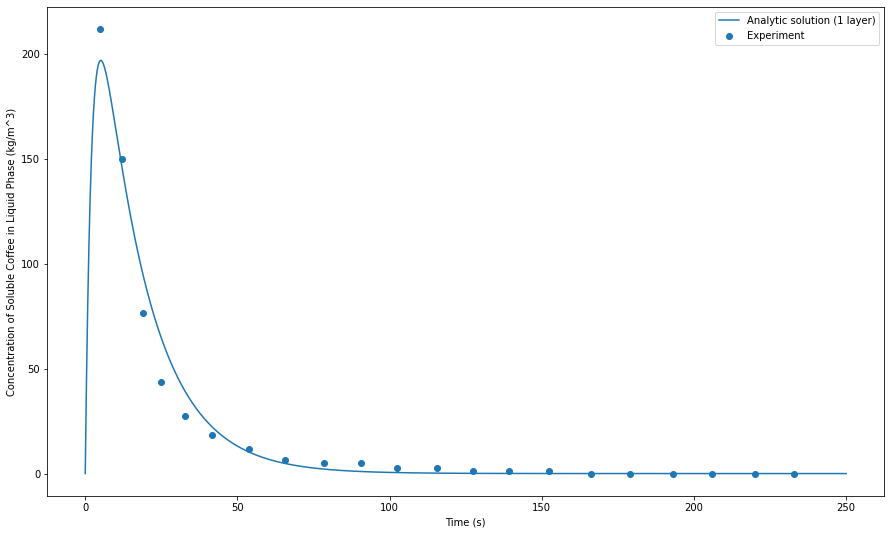

In [8]:
def get_model_c_l(t, c_l_0, c_s_0):
    # Get cefficients
    C_1 = (model_Z_2 * c_l_0 - c_s_0) / (model_Z_2 - model_Z_1)
    C_2 = -(model_Z_1 * c_l_0 - c_s_0) / (model_Z_2 - model_Z_1)

    # Get model values
    c_l_1 = np.exp(-(model_A + model_B) / 2. * model_t)
    c_l_2 = np.exp(-(model_A - model_B) / 2. * model_t)
    return  C_1 * c_l_1 + C_2 * c_l_2

# Initial conditions
model_c_l_0 = 0.

# Get model values
model_t = np.linspace(0., 250., 2500)
model_c_l = get_model_c_l(model_t, model_c_l_0, model_c_s_0)

# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(model_t, model_c_l, label='Analytic solution (1 layer)')

# Plot the experimental data
ax.scatter(expt['x'], expt['y'], label='Experiment')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee in Liquid Phase (kg/m^3)')

# Add a legend
plt.legend()

# Comparison with numerical model

Let's compare with the numerical model we developed previously. We adapt the model to use a single solid phase, with the puck initially wetted with clean water--the same initial conditions used by Moroney et al.

In [9]:
class Model(object):
    def __init__(self, rate=250., time=250., layers=1):
        self.a_l = 0.2
        self.a_s = 0.8

        self.Q = rate / (1e2)**3 / 60.
        self.A = np.pi * (59e-3 / 2)**2
        self.v_l = self.Q / (self.a_l * self.A)

        self.L = 0.0405
        self.N = layers
        self.dz = self.L / self.N

        self.d_s = 3.1823e-5

        self.rho_l = 965.3
        self.h_sl = 4.31562e-4 / self.rho_l

        self.D_v = self.d_s * self.h_sl

        self.phi_v = 0.56

        self.dt = 0.05
        self.num_t = round(time / self.dt)

        self.c_s = 358.587

        self.args = (self.v_l, self.dz, self.D_v, self.a_s, self.a_l, self.d_s, self.phi_v)
        self.args_without_flow = (0., self.dz, self.D_v, self.a_s, self.a_l, self.d_s, self.phi_v)

    @staticmethod
    def Ai(D_v, a_s, a_l, d_s):
        return (6. * D_v * a_s) / (a_l * d_s**2)

    @staticmethod
    def G(D_v, a_s, a_l, d_s, c_s, c_l):
        return Model.Ai(D_v, a_s, a_l, d_s) * (c_s - c_l)

    @staticmethod
    def H(D_v, phi_v, d_s, c_s, c_l):
        return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

    @staticmethod
    def update(y, t, v_l, dz, D_v, a_s, a_l, d_s, phi_v):
        # Parse the interleaved data
        c_l = y[::2]
        c_s = y[1::2]

        # Initialize the return value
        dy_dt = np.empty_like(y)

        # Interleaved views of the return value
        dcl_dt = dy_dt[::2]
        dcs_dt = dy_dt[1::2]

        # Compute derivatives
        dcl_dt[0] = -v_l * c_l[0] / dz + \
            Model.G(D_v, a_s, a_l, d_s, c_s[0], c_l[0])
        dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
            Model.G(D_v, a_s, a_l, d_s, c_s[1:], c_l[1:])

        dcs_dt[:] = -Model.H(D_v, phi_v, d_s, c_s, c_l)

        return dy_dt
    
    def initial_conditions(self):
        # Initial values
        cl_0 = np.array([0.] * self.N)
        cs_0 = np.array([self.c_s] * self.N)

        y0 = np.empty(2 * self.N)
        y0[::2] = cl_0
        y0[1::2] = cs_0

        return y0
    
    def run_model(self):
        # Initial conditions
        y0 = self.initial_conditions()

        # Simulation time
        t = np.linspace(0., self.num_t * self.dt, self.num_t)

        # Model the shot
        sol = odeint(Model.update, y0, t, self.args, ml=2, mu=1)

        return t, sol
    
    def do_plot(self, ax, t, sol, label=None, ls=None):
        # Get values at the outlet
        c_l = sol[:,-2]

        # Plot the values
        ax.plot(t, c_l, ls=ls, label=label)

Now we run the model.

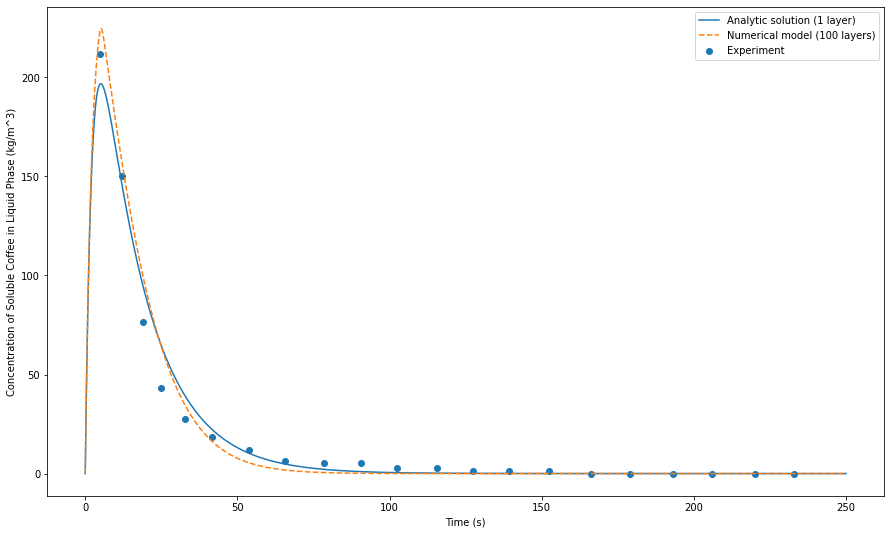

In [10]:
# Plot the analytic model
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(model_t, model_c_l, label='Analytic solution (1 layer)')

# Plot the experimental data
ax.scatter(expt['x'], expt['y'], label='Experiment')

# Plot the numerical model
model = Model(rate=250., time=250., layers=100)
t, sol = model.run_model()
model.do_plot(ax, t, sol, ls='--', label='Numerical model (100 layers)')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee in Liquid Phase (kg/m^3)')

# Add a legend
plt.legend()

This is very good agreement with the numerical model. Moroney et al. optimized the mass transfer coefficients in the numerical model to fit the experimental data, so we would expect to get an even better result if we re-optimized those parameters to fit the analytic solution.

# Transient and steady state behaviour

One reason I wanted to look at an analytic solution is because they can sometimes give insight into the dynamics underlying a process. For example, in this case we can break the analytic solution into two parts:

$$
c_l(t) = C_1 c_{l,1}(t) + C_2 c_{l,2}(t)
$$

with

$$
c_{l,1}(t) = e^{-\frac{A + B}{2} t}, \quad 
c_{l,2}(t) = e^{-\frac{A - B}{2} t}
$$

Let's see if we can figure out what each of these parts contributes to the full solution. Since

$$
A = u_l + \frac{K_l}{2} + K_s, \quad B = \sqrt{A^2 - 4 K_s u_l}
$$

we see that

$$
A \ge B \ge 0 \quad \Rightarrow \quad A + B \ge A - B \ge 0
$$

So, as $t \to \infty$, $c_{l,1}(t)$ will approach zero more quickly than $c_{l,2}(t)$. We can think of $c_{l,1}(t)$ as a "transient" behaviour and $c_{l,2}(t)$ as the "steady state" behaviour.

Let's plot the two solutions, using the parameters given above.

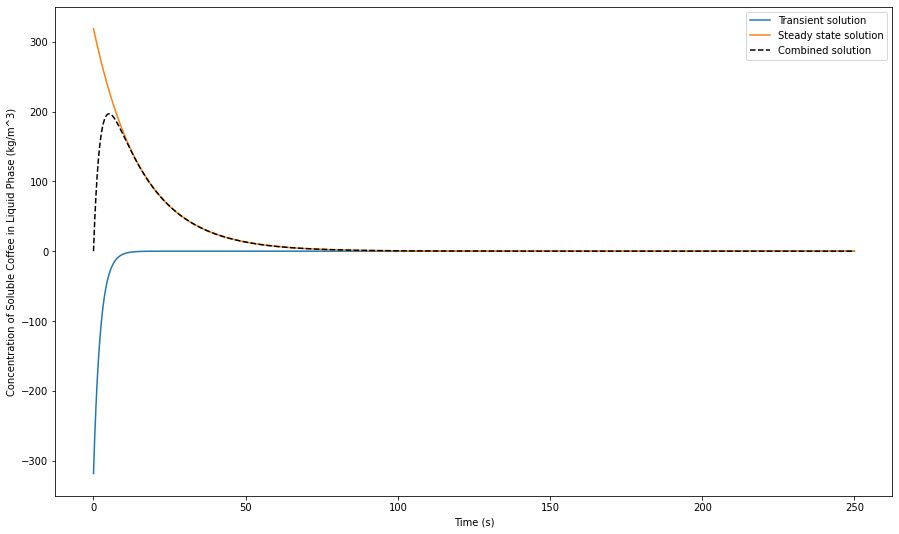

In [11]:
# Plot the values
fig, ax = plt.subplots(figsize=(15,9))

# Get cefficients
model_C_1 = (model_Z_2 * model_c_l_0 - model_c_s_0) / (model_Z_2 - model_Z_1)
model_C_2 = -(model_Z_1 * model_c_l_0 - model_c_s_0) / (model_Z_2 - model_Z_1)

# Get model values
model_c_l_1 = np.exp(-(model_A + model_B) / 2. * model_t)
model_c_l_2 = np.exp(-(model_A - model_B) / 2. * model_t)

# Plot results
ax.plot(model_t, model_C_1 * model_c_l_1, label='Transient solution')
ax.plot(model_t, model_C_2 * model_c_l_2, label='Steady state solution')
ax.plot(model_t, model_c_l, 'k--', label='Combined solution')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee in Liquid Phase (kg/m^3)')

# Add a legend
plt.legend()

We can see that the early response is driven by $c_{l,1}$, but as time goes on, $c_{l,2}$ dominates. We can think of the steady state solution as where the extraction "wants" to be, and the transient solution as how it gets there.

What conditions would lead the transient solution to vanish? In this case, we would have:

$$
C_1 = 0 \quad \Rightarrow \quad \frac{Z_2 c_l(0) - c_s(0)}{Z_2 - Z_1} = 0 \quad \Rightarrow \quad \frac{c_s(0)}{c_l(0)} = Z_2 = \frac{A + B - 2 K_s}{2 K_l}
$$

If $c_s(0) / c_l(0) < Z_2$, then we have an excess of soluble coffee in the liquid phase, and the concentration will initially drop to meet the steady state curve; on the other hand, if $c_s(0) / c_l(0) > Z_2$, then we have a deficit of soluble coffee in the liquid phase, and the concentration will initially rise to meet the steady state curve. These two cases are shown in the plot below.

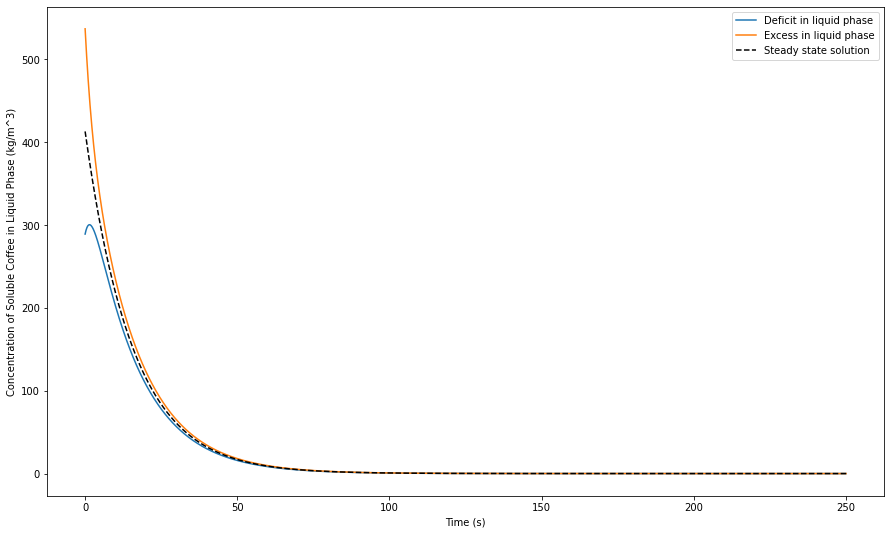

In [12]:
# Get model values
c_l_eq = get_model_c_l(model_t, model_c_s_0 / model_Z_2, model_c_s_0)
c_l_gt = get_model_c_l(model_t, model_c_s_0 / model_Z_2 * 1.3, model_c_s_0)
c_l_lt = get_model_c_l(model_t, model_c_s_0 / model_Z_2 * 0.7, model_c_s_0)

# Plot results
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(model_t, c_l_lt, label='Deficit in liquid phase')
ax.plot(model_t, c_l_gt, label='Excess in liquid phase')
ax.plot(model_t, c_l_eq, 'k--', label='Steady state solution')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee in Liquid Phase (kg/m^3)')

# Add a legend
plt.legend()

How would we get an excess or deficit of soluble coffee in the liquid phase?

The most obvious example is preinfusion. In this case, we pump water through the puck until it's completely wetted, then we stop the flow of water. Coffee is no longer carried away by the flow of water, so it accumulates in the liquid phase. When we start the flow of water again, the first liquid to come out of the portafilter contains an excess of soluble coffee.

This may also occur as a normal part of the wetting process. For example, if the ground coffee doesn't pass solubles to the liquid phase as efficiently until it's completely wetted, then we would expect the first drops out of the portafilter to contain a deficit of soluble coffee, compared to the steady state solution.

# Conclusion

We have developed an analytic solution to a simplified model of espresso extraction. This model ties the underlying physical attributes of the ground coffee to things we can observe--i.e., the concentration of soluble coffee in the liquid coming out of the portafilter.

Next, we will try to use this model to infer the physical attributes from experimental measurements of total dissolved solids.

# References

[1] https://doi.org/10.1371/journal.pone.0219906